In [3]:
ALL_SOURCE_BOOKS = ['BR','PH','MM','HotDQ','RoT','DMG','PotA','OotA','SCAG','CoS','SKT','VGtM','TftYP','ToA','XGtE','MToF','WDH','WDotMM','GGtR','GoS','BGDiA','ERftLW','EGtW','MOoT','IDRotF','TCoE','CM','FToD']
ALL_RULES_BOOKS = ['BR','PH','MM','DMG','SCAG','VGtM','XGtE','MToF','GGtR','ERftLW','EGtW','MOoT','TCoE','FToD']
ALL_ADVENTURE_BOOKS = ['HotDQ','RoT','PotA','OotA','CoS','SKT','TftYP','ToA','WDH','WDotMM','GoS','BGDiA','IDRotF','CM']

In [4]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

METADATA = {'Contributor': 'T. Dunn'}

df0 = pd.read_csv('monster-cr-and-xp.csv')  # 'Book','Page','Type','Category','Legendary','CR','PB','XP',
                                            # 'HP','AC','adj HP','adj AC',
                                            # 'AB','adj AB','DPR', 'adj DPR',
                                            # 'D-CR DMG','O-CR DMG','CR DMG','XP DMG', 
                                            # 'eHP','D-eCR','eDPR','O-eCR','eCR','eXP'
df0.insert(25, 'C-CR DMG', 0.5*(df0['D-CR DMG'] + df0['O-CR DMG']), True)
df0.insert(26, 'D-CR Delta DMG', df0['D-CR DMG'] - df0['CR'], True)
df0.insert(27, 'O-CR Delta DMG', df0['O-CR DMG'] - df0['CR'], True)
df0.insert(28, 'CR Delta DMG', df0['CR DMG'] - df0['CR'], True)
dfD = pd.read_csv('dmg-targets-cr-and-xp.csv') # 'CR','PB','XP','AC','HP Mean','AB','DPR Mean'
dfD.insert(7, 'eHP Mean', dfD['HP Mean']*np.power(1.05, dfD['AC']-12), True)
dfD.insert(8, 'eDPR Mean', dfD['DPR Mean']*np.power(1.05, dfD['AB']-2), True)
dfD.insert(9, 'eXP Mean', 0.25*dfD['eHP Mean']*dfD['eDPR Mean'], True)
dfD = dfD[dfD['CR'].between(1,30)]
dfD.set_index('CR', inplace=True)

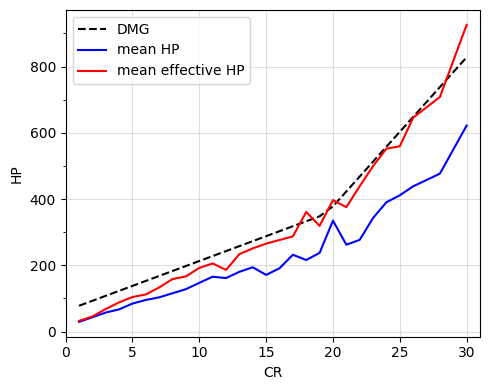

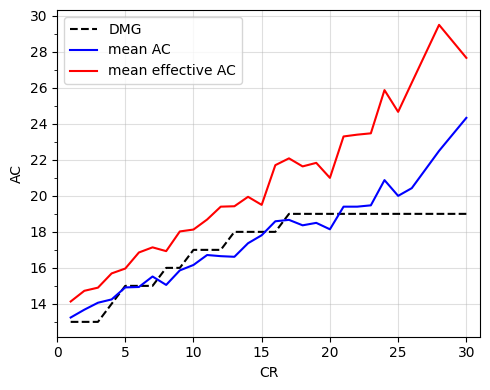

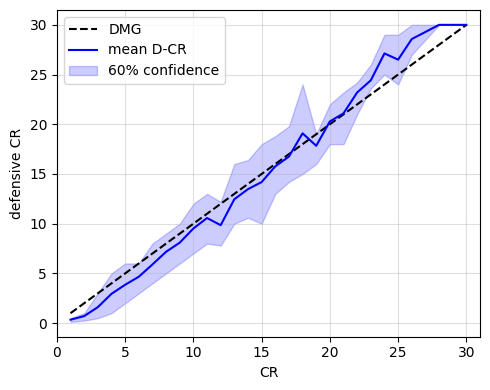

In [517]:
# AC, HP, D-CR
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

dfD0 = dfD
dfG = df0.groupby('CR').mean()
dfU = df0.groupby('CR').quantile(0.8)
dfL = df0.groupby('CR').quantile(0.2)

# hit points
fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlim=[0, 31], xlabel='CR', ylabel='HP')
ax.plot(dfD0.index, dfD0['HP Mean'], '--', color='k', label='DMG')
ax.plot(dfG.index, dfG['HP'], '-', color='b', label='mean HP')
ax.plot(dfG.index, dfG['adj HP'], '-', color='r', label='mean effective HP')
ax.yaxis.set_major_locator(MultipleLocator(200))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(100))
ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

plt.savefig('hp-vs-cr.svg', metadata=METADATA)

# armor class
fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlim=[0, 31], xlabel='CR', ylabel='AC')
ax.plot(dfD0.index, dfD0['AC'], '--', color='k', label='DMG')
ax.plot(dfG.index, dfG['AC'], '-', color='b', label='mean AC')
ax.plot(dfG.index, dfG['adj AC'], '-', color='r', label='mean effective AC')
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

plt.savefig('ac-vs-cr.svg', metadata=METADATA)

# D-CR
fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlim=[0, 31], xlabel='CR', ylabel='defensive CR')
ax.plot(dfD0.index, dfD0.index, '--', color='k', label='DMG')
ax.plot(dfG.index, dfG['D-CR DMG'], '-', color='b', label='mean D-CR')
ax.fill_between(dfG.index, dfL['D-CR DMG'], dfU['D-CR DMG'], alpha=0.2, color='b', label='60% confidence')
ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

plt.savefig('d-cr-vs-cr.svg', metadata=METADATA)

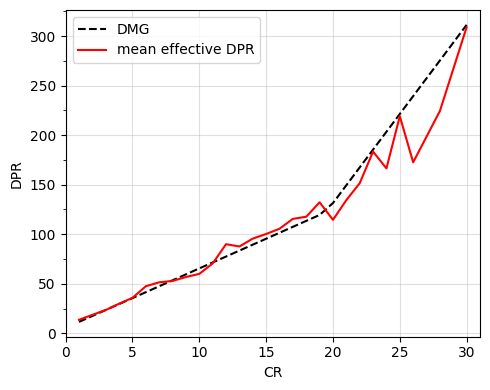

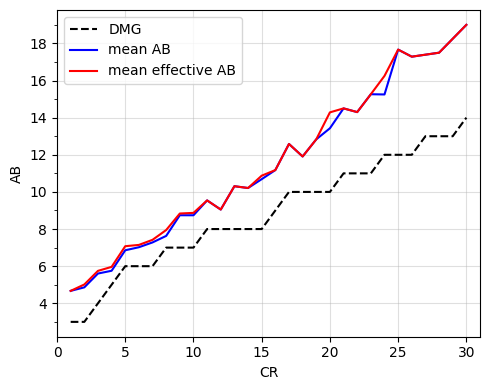

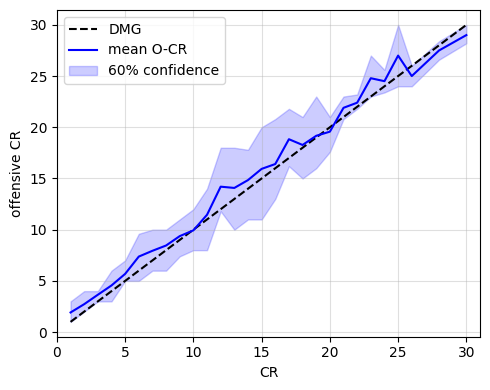

In [522]:
# DPR, AB, O-CR
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

dfD0 = dfD
dfG = df0.groupby('CR').mean()
dfU = df0.groupby('CR').quantile(0.8)
dfL = df0.groupby('CR').quantile(0.2)

# damage per round
fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlim=[0, 31], xlabel='CR', ylabel='DPR')
ax.plot(dfD0.index, dfD0['DPR Mean'], '--', color='k', label='DMG')
#ax.plot(dfG.index, dfG['DPR'], '-', color='b', label='mean DPR')
ax.plot(dfG.index, dfG['DPR'], '-', color='r', label='mean effective DPR')
ax.yaxis.set_major_locator(MultipleLocator(50))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(25))
ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

plt.savefig('dpr-vs-cr.svg', metadata=METADATA)

# attack bonus
fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlim=[0, 31], xlabel='CR', ylabel='AB')
ax.plot(dfD0.index, dfD0['AB'], '--', color='k', label='DMG')
ax.plot(dfG.index, dfG['AB'], '-', color='b', label='mean AB')
ax.plot(dfG.index, dfG['adj AB'], '-', color='r', label='mean effective AB')
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

plt.savefig('ab-vs-cr.svg', metadata=METADATA)

# O-CR
fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlim=[0, 31], xlabel='CR', ylabel='offensive CR')
ax.plot(dfD0.index, dfD0.index, '--', color='k', label='DMG')
ax.plot(dfG.index, dfG['O-CR DMG'], '-', color='b', label='mean O-CR')
ax.fill_between(dfG.index, dfL['O-CR DMG'], dfU['O-CR DMG'], alpha=0.2, color='b', label='60% confidence')
ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

plt.savefig('o-cr-vs-cr.svg', metadata=METADATA)

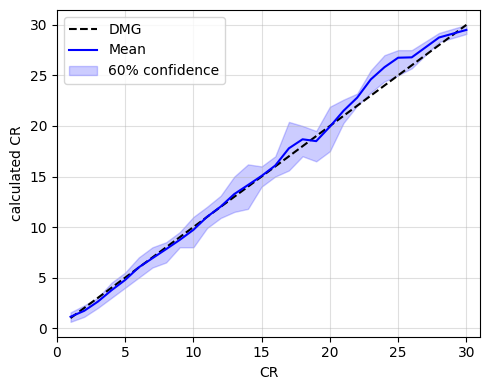

In [524]:
# DMG CR
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

dfD0 = dfD
dfG = df0.groupby('CR').mean()
dfU = df0.groupby('CR').quantile(0.8)
dfL = df0.groupby('CR').quantile(0.2)

# CR
col = 'C-CR DMG'
ylab = 'calculated CR'
fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlim=[0, 31], xlabel='CR', ylabel=ylab)
ax.plot(dfD0.index, dfD0.index, '--', color='k', label='DMG')
ax.plot(dfG.index, dfG[col], '-', color='b', label='Mean')
ax.fill_between(dfG.index, dfL[col], dfU[col], alpha=0.2, color='b', label='60% confidence')

ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

plt.savefig('dmg-cr-vs-cr.svg', metadata=METADATA)

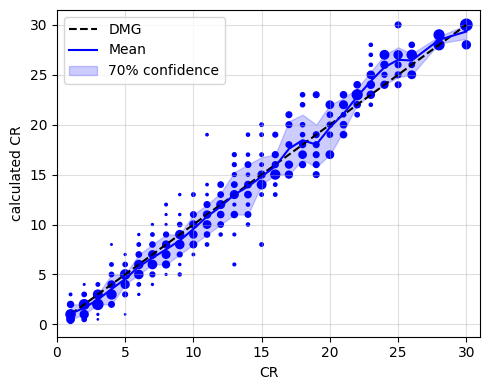

In [497]:
# DMG CR
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

dfD0 = dfD
dfG = df0.groupby('CR').mean()
dfU = df0.groupby('CR').quantile(0.85)
dfL = df0.groupby('CR').quantile(0.15)

# CR
col = 'CR DMG'
ylab = 'calculated CR'
fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlim=[0, 31], xlabel='CR', ylabel=ylab)
ax.grid(which='major', axis='both', alpha=0.4)

ax.plot(dfD0.index, dfD0.index, '--', color='k', label='DMG')
ax.fill_between(dfG.index, dfL[col], dfU[col], alpha=0.2, color='b', label='70% confidence')
ax.plot(dfG.index, dfG[col], '-', color='b', label='Mean')

dfC = df0.groupby(['CR']).size().to_frame('Count')
dft = df0.groupby(['CR', col]).size().to_frame('Count').reset_index()
for CR in dfC.index:
    n = dfC['Count'].loc[CR]
    mask = dft['CR'].isin([CR])
    dft.loc[mask, 'Count'] = 100*dft.loc[mask, 'Count']/n
ax.scatter('CR', col, s='Count', data=dft, alpha=1.0, color='b', label='')

ax.legend(loc='upper left')


#plt.savefig('dmg-cr-vs-cr.svg', metadata=METADATA)

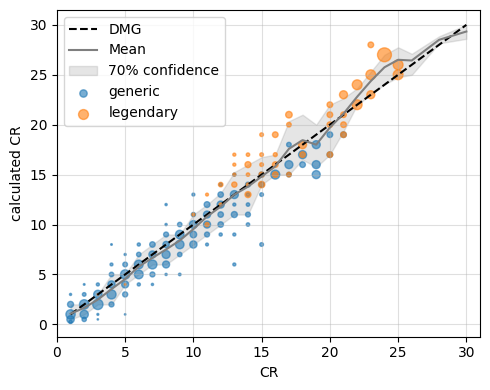

In [501]:
# DMG CR
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

dfD0 = dfD
dfG = df0.groupby('CR').mean()
dfU = df0.groupby('CR').quantile(0.85)
dfL = df0.groupby('CR').quantile(0.15)

# CR
col = 'CR DMG'
ylab = 'calculated CR'
fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlim=[0, 31], xlabel='CR', ylabel=ylab)
ax.grid(which='major', axis='both', alpha=0.4)

ax.plot(dfD0.index, dfD0.index, '--', color='k', label='DMG')
ax.fill_between(dfG.index, dfL[col], dfU[col], alpha=0.2, color='#7f7f7f', label='70% confidence')
ax.plot(dfG.index, dfG[col], '-', color='#7f7f7f', label='Mean')

#cats = ['generic','legendary','unique']
#colors = ['#1f77b4','#ff7f0e','#2ca02c']
cats = ['generic','legendary']
colors = ['#1f77b4','#ff7f0e']
dfC = df0[df0['Category'].isin(cats)].groupby(['CR']).size().to_frame('Count')
dft = df0.groupby(['CR', 'Category', col]).size().to_frame('Count').reset_index()
for CR in dfC.index:
    n = dfC['Count'].loc[CR]
    mask = dft['CR'].isin([CR])
    dft.loc[mask, 'Count'] = 100*dft.loc[mask, 'Count']/n
for cat, co in zip(cats, colors):
    ax.scatter('CR', col, s='Count', data=dft[dft['Category'].isin([cat])], alpha=0.6, color=co, label=cat)

ax.legend(loc='upper left')


#plt.savefig('dmg-cr-vs-cr.svg', metadata=METADATA)

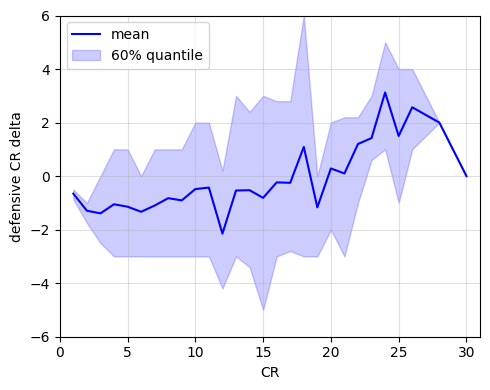

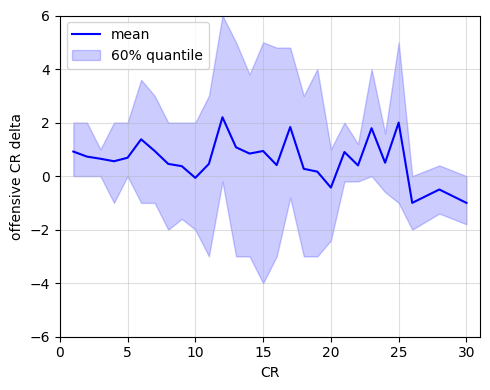

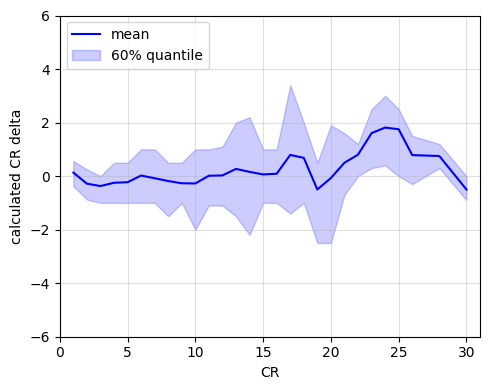

In [409]:
# DMG CR deltas
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

dfD0 = dfD
df1 = df0[df0['CR'].between(1,30) & df0['Category'].isin(['generic','legendary','unique'])]
dfG = df1.groupby('CR').mean()
dfU = df1.groupby('CR').quantile(0.8)
dfL = df1.groupby('CR').quantile(0.2)

# D-CR
col = 'D-CR DMG'
ylab = 'defensive CR delta'
fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlim=[0, 31], ylim=[-6,6], xlabel='CR', ylabel=ylab)
ax.plot(dfG.index, dfG[col] - dfG.index, '-', color='b', label='mean')
ax.fill_between(dfG.index, dfL[col] - dfG.index, dfU[col] - dfG.index, alpha=0.2, color='b', label='60% quantile')
ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

#plt.savefig('dmg-d-cr-delta-vs-cr.png')

# O-CR
col = 'O-CR DMG'
ylab = 'offensive CR delta'
fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlim=[0, 31], ylim=[-6,6], xlabel='CR', ylabel=ylab)
ax.plot(dfG.index, dfG[col] - dfG.index, '-', color='b', label='mean')
ax.fill_between(dfG.index, dfL[col] - dfG.index, dfU[col] - dfG.index, alpha=0.2, color='b', label='60% quantile')
ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

#plt.savefig('dmg-o-cr-delta-vs-cr.svg', metadata=METADATA)

# CR
col = 'C-CR DMG'
ylab = 'calculated CR delta'
fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlim=[0, 31], ylim=[-6,6], xlabel='CR', ylabel=ylab)
ax.plot(dfG.index, dfG[col] - dfG.index, '-', color='b', label='mean')
ax.fill_between(dfG.index, dfL[col] - dfG.index, dfU[col] - dfG.index, alpha=0.2, color='b', label='60% quantile')
ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

#plt.savefig('dmg-cr-delta-vs-cr.svg', metadata=METADATA)

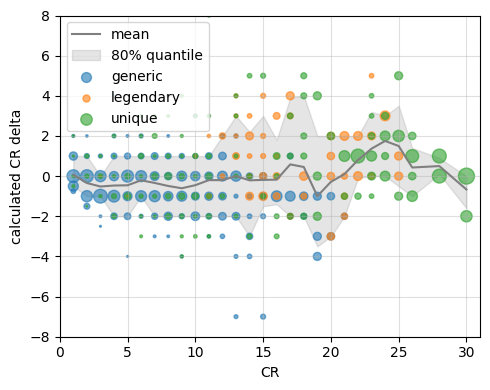

In [514]:
# DMG CR deltas
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

cats = ['generic','legendary','unique']
colors = ['#1f77b4','#ff7f0e','#2ca02c']
#cats = ['generic','legendary']
#colors = ['#1f77b4','#ff7f0e']

dfD0 = dfD
df1 = df0[df0['CR'].between(1,30) & df0['Category'].isin(cats)]
dfG = df1.groupby('CR').mean()
dfU = df1.groupby('CR').quantile(0.90, interpolation='linear')
dfL = df1.groupby('CR').quantile(0.10, interpolation='linear')

# CR
col = 'CR Delta DMG'
ylab = 'calculated CR delta'
fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlim=[0, 31], ylim=[-8,8], xlabel='CR', ylabel=ylab)
ax.grid(which='major', axis='both', alpha=0.4)

ax.plot(dfG.index, dfG[col], '-', color='#7f7f7f', label='mean')
ax.fill_between(dfG.index, dfL[col], dfU[col], alpha=0.2, color='#7f7f7f', label='80% quantile')

dfC = df0.groupby(['CR']).size().to_frame('Count')
dft = df0.groupby(['CR', 'Category', col]).size().to_frame('Count').reset_index()
for CR in dfC.index:
    n = dfC['Count'].loc[CR]
    mask = dft['CR'].isin([CR])
    dft.loc[mask, 'Count'] = 200*dft.loc[mask, 'Count']/n

for cat, co in zip(cats, colors):
    ax.scatter('CR', col, s='Count', data=dft[dft['Category'].isin([cat])], alpha=0.6, color=co, label=cat)

ax.legend(loc='upper left')

#plt.savefig('dmg-cr-delta-vs-cr.svg', metadata=METADATA)

In [525]:
# DMG CR deltas
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

cats = ['generic','legendary','unique']
colors = ['#1f77b4','#ff7f0e','#2ca02c']
#cats = ['generic','legendary']
#colors = ['#1f77b4','#ff7f0e']

dfD0 = dfD
df1 = df0[ (df0['CR Delta DMG'].between(-4,4) == False) & df0['CR'].between(1,30) & df0['Category'].isin(cats)]
df1

,Book,Page,Type,Category,Legendary,CR,PB,XP,HP,AC,...,eHP,D-eCR,eDPR,O-eCR,eCR,eXP,C-CR DMG,D-CR Delta DMG,O-CR Delta DMG,CR Delta DMG
3,MToF,162.0,fiend,generic,N,15.0,5,13000.0,187.5,18.0,...,345.4,13.0,38.9,5.0,8.0,3355.0,8.5,-3.0,-10.0,-7.0
495,MM,197.0,monstrosity,legendary,LL,23.0,7,50000.0,472.5,18.0,...,961.0,27.0,590.4,30.0,29.0,141854.0,28.0,3.0,7.0,5.0
688,MM,257.0,fiend,generic,N,13.0,5,10000.0,110.5,16.0,...,221.1,8.0,23.0,3.0,4.0,1270.0,6.0,-5.0,-9.0,-7.0
742,RoT,92.0,humanoid,unique,L,11.0,4,7200.0,150.0,16.0,...,455.8,17.0,196.8,20.0,19.0,22426.0,19.0,8.0,8.0,8.0
755,WDotMM,174.0,construct,unique,N,14.0,5,11500.0,310.0,20.0,...,458.0,18.0,235.9,21.0,20.0,27006.0,19.0,3.0,7.0,5.0
783,SKT,224.0,monstrosity,unique,LL,25.0,8,75000.0,472.5,18.0,...,1390.9,30.0,690.2,30.0,30.0,240002.0,30.0,5.0,5.0,5.0
822,CoS,239.0,undead,unique,LL,15.0,5,13000.0,144.5,16.0,...,566.2,21.0,183.9,19.0,20.0,26025.0,20.5,6.0,5.0,5.0
959,PotA,220.0,elemental,unique,LL,18.0,6,20000.0,283.5,22.0,...,923.1,26.0,253.2,22.0,23.0,58439.0,23.5,7.0,4.0,5.0


In [ ]:
# DMG CR deltas
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

column = 'Type'

df1 = df0[df0['CR'].between(1,30)]
dfG = df1.groupby(column).mean()

x = dfG.index.tolist()
x_pos = [i for i, _ in enumerate(x)]
y = dfG['CR Delta DMG'].to_list()



ax.barh(x_pos, y)

plt.yticks(x_pos, x)

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))

#ax.grid(which='major', axis='both', alpha=0.4)

df1.groupby(column).std()['CR Delta DMG']




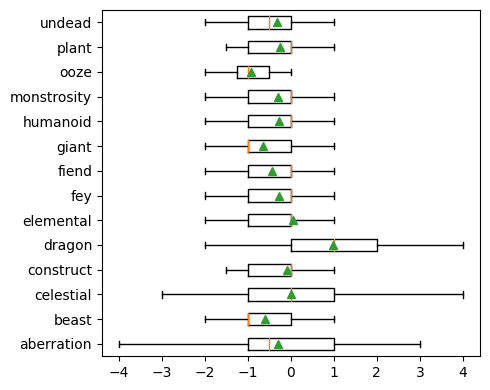

In [411]:
df1 = df0[df0['CR'].between(1,30)]

col = 'Type'
groups = df1[col].sort_values().unique()

fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes()
bp = ax.boxplot(tuple(df1[df1[col].isin([g])]['CR Delta DMG'] for g in groups), 
    labels=groups, showmeans=True, vert=False, showfliers=False, patch_artist=False)


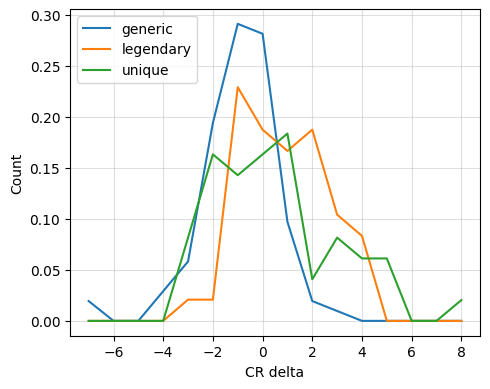

In [412]:
# DMG CR deltas
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

df1 = df0[df0['CR'].between(10,20)]

rMin = df1['CR Delta DMG'].min()
rMax = df1['CR Delta DMG'].max()
rDel = 1.0
nBins = int(np.round(1 + (rMax - rMin)/rDel))
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)
x = np.linspace(rMin, rMax, nBins)

fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlabel='CR delta', ylabel='Count')
y, t = np.histogram(df1[df1['Category'].isin(['generic'])]['CR Delta DMG'], rRange, density=True); ax.plot(x, y, label='generic')
y, t = np.histogram(df1[df1['Category'].isin(['legendary'])]['CR Delta DMG'], rRange, density=True); ax.plot(x, y, label='legendary')
y, t = np.histogram(df1[df1['Category'].isin(['unique'])]['CR Delta DMG'], rRange, density=True); ax.plot(x, y, label='unique')
ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

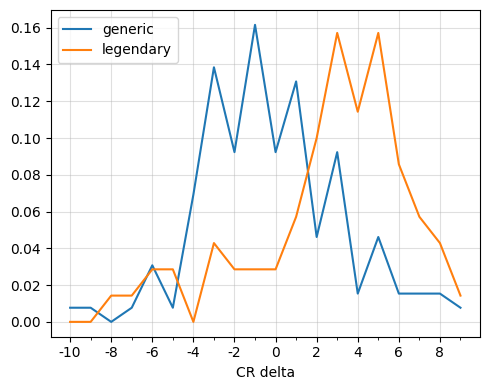

In [413]:
# DMG CR deltas
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

df1 = df0[df0['CR'].between(10,20)]

column = 'O-CR Delta DMG'
rMin = df1[column].min()
rMax = df1[column].max()
rDel = 1.0
nBins = int(np.round(1 + (rMax - rMin)/rDel))
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)
x = np.linspace(rMin, rMax, nBins)

fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlabel='CR delta')
y, t = np.histogram(df1[df1['Legendary'].isin(['N'])][column], rRange, density=True); ax.plot(x, y, label='generic')
y, t = np.histogram(df1[df1['Legendary'].isin(['L','LL'])][column], rRange, density=True); ax.plot(x, y, label='legendary')
ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(1))

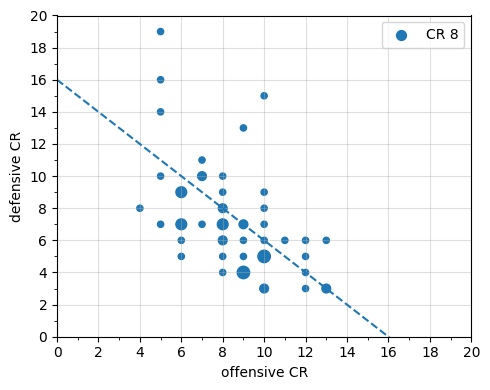

In [6]:
# DPR vs HP
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

CRs = [8]
#colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
colors = colors[0:3]

fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlim=[0,20], ylim=[0,20], xlabel='offensive CR', ylabel='defensive CR')

for CR, c in zip(CRs, colors):
    df1 = df0[df0['CR'].isin([CR]) & df0['Category'].isin(['generic','legendary','unique'])]
    dft = df1.groupby(['D-CR DMG', 'O-CR DMG']).size().to_frame('Count').reset_index()
    dft['Count'] = dft['Count']*20
    #ax.scatter(df1['O-CR DMG'], df1['D-CR DMG'], label='CR='+str(CR), color=c)
    ax.scatter('O-CR DMG', 'D-CR DMG', s='Count', alpha=1.0, data=dft, label='CR {}'.format(CR))

ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(1))

ax.legend()
ax.grid(which='major', axis='both', alpha=0.4)

x = np.linspace(0, 30, 31)
XP = dfD['XP'].values
for CR, c in zip(CRs, colors):
    ax.plot(x, 2*CR - x, '--', color=c)

In [415]:
df1 = df0[df0['CR'].isin([10]) & df0['Category'].isin(['generic','legendary','unique'])]
tmp = df1.groupby(['D-CR DMG', 'O-CR DMG']).size().to_frame('Count').reset_index()
tmp['Count'].max()

2

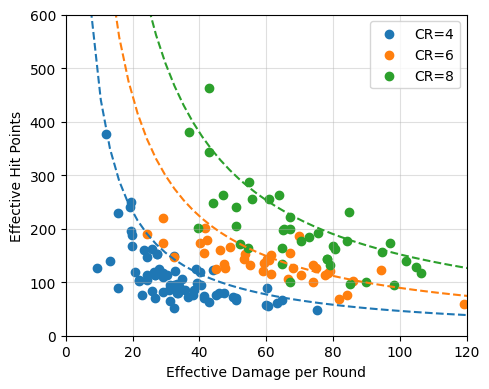

In [416]:
# DPR vs HP
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

CRs = [4,6,8]
#colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
colors = colors[0:3]

fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlim=[0,120], ylim=[0,600])

ax.set_xlabel('Effective Damage per Round')
#ax.xaxis.set_major_locator(MultipleLocator(5))
#ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
#ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.set_ylabel('Effective Hit Points')
#ax.yaxis.set_major_locator(MultipleLocator(1.0))
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
#ax.yaxis.set_minor_locator(MultipleLocator(0.5))

for CR, c in zip(CRs, colors):
    df1 = df0[df0['CR'].isin([CR]) & df0['Category'].isin(['generic','legendary'])]
    ax.scatter(df1['eDPR'], df1['eHP'], label='CR='+str(CR), color=c)

ax.legend()
ax.grid(which='major', axis='both', alpha=0.4)

x = np.linspace(5, 140, 50)
XP = dfD['XP'].values
for CR, c in zip(CRs, colors):
    ax.plot(x, 4*dfD.loc[CR]['eXP Mean']/x, '--', color=c)

In [ ]:
# plot calculated offensive skew vs target CR
#
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

plt.figure()
ax = plt.axes(xlim=[0, 31], ylim=[-1, 1])

ci = 0.75

df1 = df0[df0['CR'].between(1, 30) & df0['Legendary'].isin(['N','L','LL'])]
df1 = df1[['CR','eXP Skew']]

# plot points data
ax.scatter(df1['CR'], df1['eXP Skew'], s=8, color='r')

# plot mean
#dfM = df1.groupby('CR').mean()
#x  = dfM.index.to_series()
#yM = dfM['eXP Skew']
#ax.plot(x, yM, '-', color='r', label='mean')

# plot median
dfM = df1.groupby('CR').quantile(q=0.5, interpolation='linear')
x  = dfM.index.to_series()
yM = dfM['eXP Skew']
ax.plot(x, yM, '-', color='r', label='median')

# plot confidency interfal
dfU = df1.groupby('CR').quantile(q=0.5+ci/2, interpolation='linear')
yU = dfU['eXP Skew']
dfD = df1.groupby('CR').quantile(q=0.5-ci/2, interpolation='linear')
yD = dfD['eXP Skew']
ax.fill_between(x, yD, yU, color='r', alpha=.1, label='75% confidency')

# plot 1-to-1 line
ax.plot(x, x*0.0, '--', color='k')

# add labels
ax.set_xlabel('CR')
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.set_ylabel('Offensive Skew')
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

ax.legend()

#plt.savefig('../media/offensive-skew-vs-CR.svg', metadata=METADATA)